# Explore [Biomass Estimation](https://www.drivendata.org/competitions/99/biomass-estimation/) contest data

## Setup

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from os.path import join
# need to use multiprocess fork which works in Jupyter notebooks
from multiprocess import Pool
import os

import pandas as pd
from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from biomass.dataset import BiomassDataset
from biomass.transforms import SentinelBandNormalize

In [18]:
root_dir = '/Users/lewfish/data/biomass/'
dataset_dir = join(root_dir, 'dataset')
output_dir = join(root_dir, 'output')
data_plots_dir = join(output_dir, 'data-plots')
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(data_plots_dir, exist_ok=True)

plt.rcParams['figure.facecolor'] = 'white'


## Inspect Metadata

In [19]:
biomass_ds = BiomassDataset(dataset_dir, 'train')
metadata = biomass_ds.metadata

In [20]:
metadata.features_df.head()

filename   chip_id satellite  split      month     size  \
0  0003d2eb_S1_00.tif  0003d2eb        S1  train  September  1049524   
1  0003d2eb_S1_01.tif  0003d2eb        S1  train    October  1049524   
2  0003d2eb_S1_02.tif  0003d2eb        S1  train   November  1049524   
3  0003d2eb_S1_03.tif  0003d2eb        S1  train   December  1049524   
4  0003d2eb_S1_04.tif  0003d2eb        S1  train    January  1049524   

        cksum                                          s3path_us  \
0  3953454613  s3://drivendata-competition-biomassters-public...   
1  3531005382  s3://drivendata-competition-biomassters-public...   
2  1401197002  s3://drivendata-competition-biomassters-public...   
3  3253084255  s3://drivendata-competition-biomassters-public...   
4  2467836265  s3://drivendata-competition-biomassters-public...   

                                           s3path_eu  \
0  s3://drivendata-competition-biomassters-public...   
1  s3://drivendata-competition-biomassters-public...   
2  s3://drivendata-competition-biomassters-public...   
3  s3://drivendata-competition-biomassters-public...   
4  s3://drivendata-competition-biomassters-public...   

                                           s3path_as corresponding_agbm  
0  s3://drivendata-competition-biomassters-public...  0003d2eb_agbm.tif  
1  s3://drivendata-competition-biomassters-public...  0003d2eb_agbm.tif  
2  s3://drivendata-competition-biomassters-public...  0003d2eb_agbm.tif  
3  s3://drivendata-competition-biomassters-public...  0003d2eb_agbm.tif  
4  s3://drivendata-competition-biomassters-public...  0003d2eb_agbm.tif

In [21]:
metadata.labels_df.head()

filename   chip_id    size       cksum  \
0  0003d2eb_agbm.tif  0003d2eb  262482  2036246549   
1  000aa810_agbm.tif  000aa810  262482  2858468457   
2  000d7e33_agbm.tif  000d7e33  262482   277850822   
3  00184691_agbm.tif  00184691  262482  3502312579   
4  001b0634_agbm.tif  001b0634  262482  2397957274   

                                           s3path_us  \
0  s3://drivendata-competition-biomassters-public...   
1  s3://drivendata-competition-biomassters-public...   
2  s3://drivendata-competition-biomassters-public...   
3  s3://drivendata-competition-biomassters-public...   
4  s3://drivendata-competition-biomassters-public...   

                                           s3path_eu  \
0  s3://drivendata-competition-biomassters-public...   
1  s3://drivendata-competition-biomassters-public...   
2  s3://drivendata-competition-biomassters-public...   
3  s3://drivendata-competition-biomassters-public...   
4  s3://drivendata-competition-biomassters-public...   

                                           s3path_as  
0  s3://drivendata-competition-biomassters-public...  
1  s3://drivendata-competition-biomassters-public...  
2  s3://drivendata-competition-biomassters-public...  
3  s3://drivendata-competition-biomassters-public...  
4  s3://drivendata-competition-biomassters-public...

In [22]:
features_df = metadata.features_df
chip_df = features_df.loc[features_df.chip_id.isin(['28ac85b5'])]

## Compute statistics on size of dataset

The number of `chip_id`s per split:

In [23]:
features_df.groupby('chip_id').first().split.value_counts()

train    8689
test     2773
Name: split, dtype: int64

The number of 1-band rasters per split:

In [24]:
features_df.split.value_counts()

train    189078
test      63348
Name: split, dtype: int64

## Download subset of data

Get a small subset of the training `chip_id`s (after seeding and randomly shuffling)

In [25]:
subset_sz = 100

chip_ids = metadata.get_chip_ids('train')
chip_ids = chip_ids[0:subset_sz]
chip_ids

array(['0003d2eb', '000aa810', '000d7e33', '00184691', '001b0634',
       '001eb75a', '0029317e', '002fb84c', '00301627', '003a2b5b',
       '003ab939', '0040c3a8', '004ef4ec', '0058fedc', '0060c0a5',
       '00635116', '0080ae28', '0083efdf', '008a52a9', '008be628',
       '008d48bf', '009957ba', '0099b501', '00a0d9d4', '00a0fcf3',
       '00b7c361', '00c03fbe', '00cb4c3e', '00d97746', '00da2ec1',
       '00de40a4', '00e1d23f', '00e6b793', '00edfd51', '00eee261',
       '00efbedd', '00f898a5', '00fc19b1', '00fd0698', '00ff36dd',
       '010966cb', '011909e9', '011bc55a', '0131497d', '0140e251',
       '01417893', '0147ad59', '014e57fe', '01503e8a', '01567168',
       '0157cf88', '01583b0f', '0177cc36', '017f206b', '01829c8b',
       '018df98c', '0193cab1', '01a92708', '01ac99fb', '01b0ad1c',
       '01b7f786', '01bc24f4', '01ccc4cf', '01ce06f5', '01e1a71e',
       '01ea0701', '01edae7b', '01f1fef8', '01f32968', '01f7f810',
       '01fb0167', '01fec683', '020aefcc', '020c0e93', '0215bd

Download a subset of the data locally

In [11]:
chip_ids = metadata.get_chip_ids('test_chip_ids')
biomass_ds.download_data(chip_ids)

A Jupyter Widget

Also download some test chips.

In [14]:
test_biomass_ds = BiomassDataset(dataset_dir, 'test')
test_chip_ids = metadata.get_chip_ids('test')[0:5]
test_biomass_ds.download_data(test_chip_ids)

A Jupyter Widget

## Load and visualize data

Load and plot a single chip.

torch.Size([12, 15, 256, 256])
torch.Size([256, 256])
dict_keys(['chip_id', 'full_months', 'partial_months', 's1_masks', 's2_masks', 'months'])


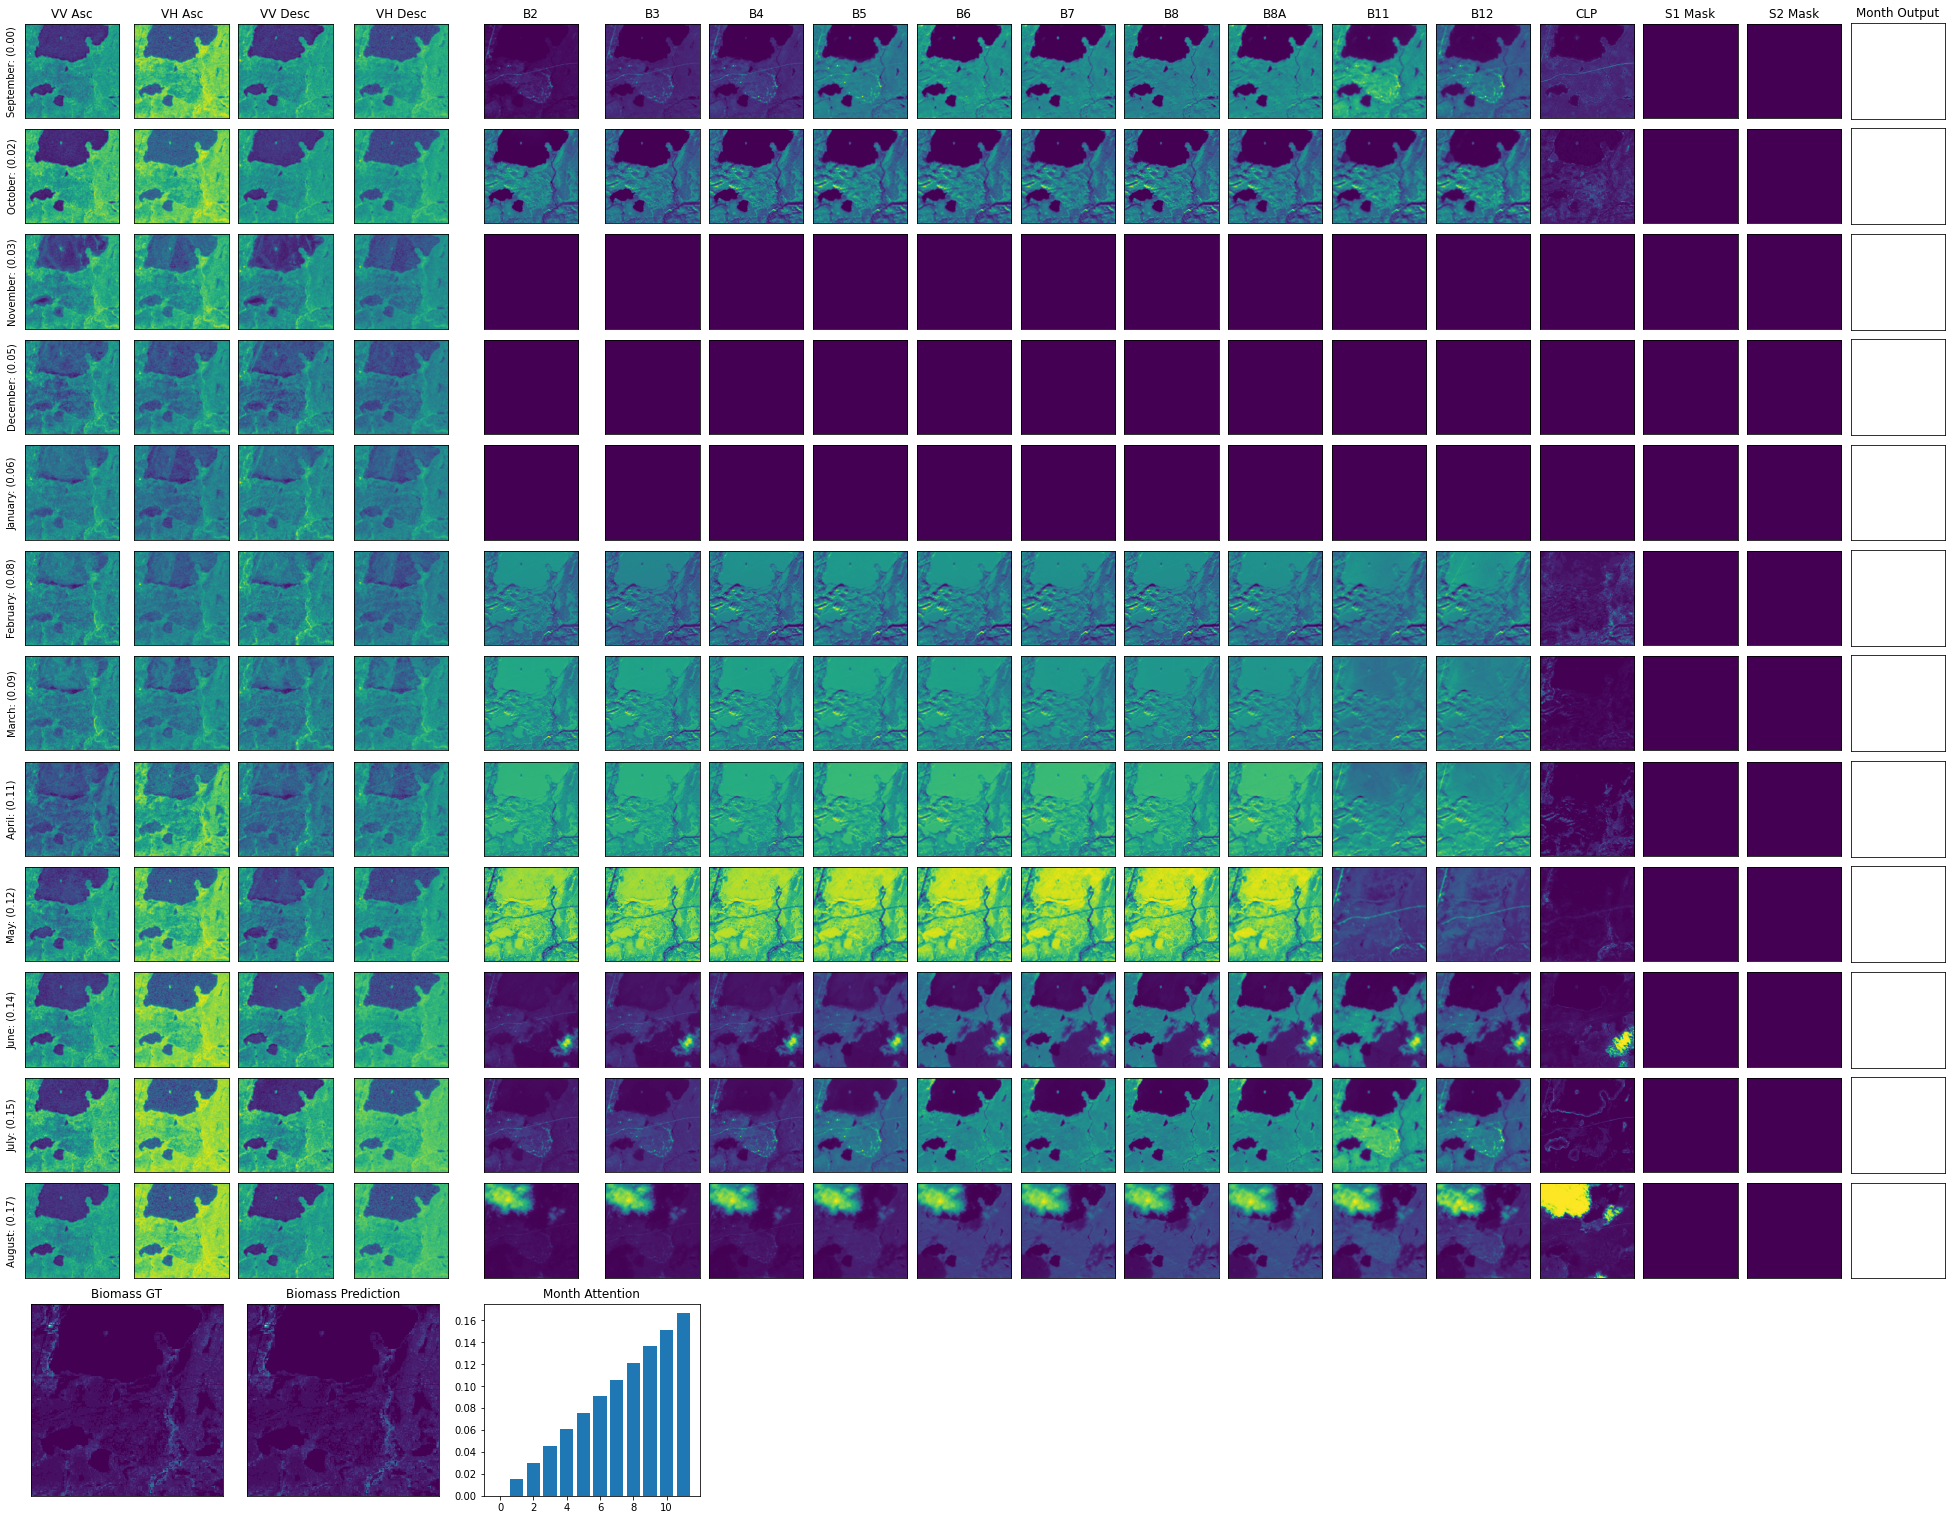

In [34]:
biomass_ds = BiomassDataset(
    dataset_dir, 'train', chip_ids=['0003d2eb'], transform=SentinelBandNormalize())

x, y, chip_metadata = biomass_ds[0]
print(x.shape)
print(y.shape)
print(chip_metadata.keys())

# Simulate output
month_weights = torch.arange(12) / torch.arange(12).sum()
output = y + torch.randn_like(y) * 5
z = {'output': output, 'month_weights': month_weights}
biomass_ds.plot_sample(x, y, chip_metadata, z=z)


Read individual months from dataset instead of whole years as items.

torch.Size([1, 15, 256, 256])
torch.Size([256, 256])
dict_keys(['chip_id', 'full_months', 'partial_months', 's1_masks', 's2_masks', 'months'])


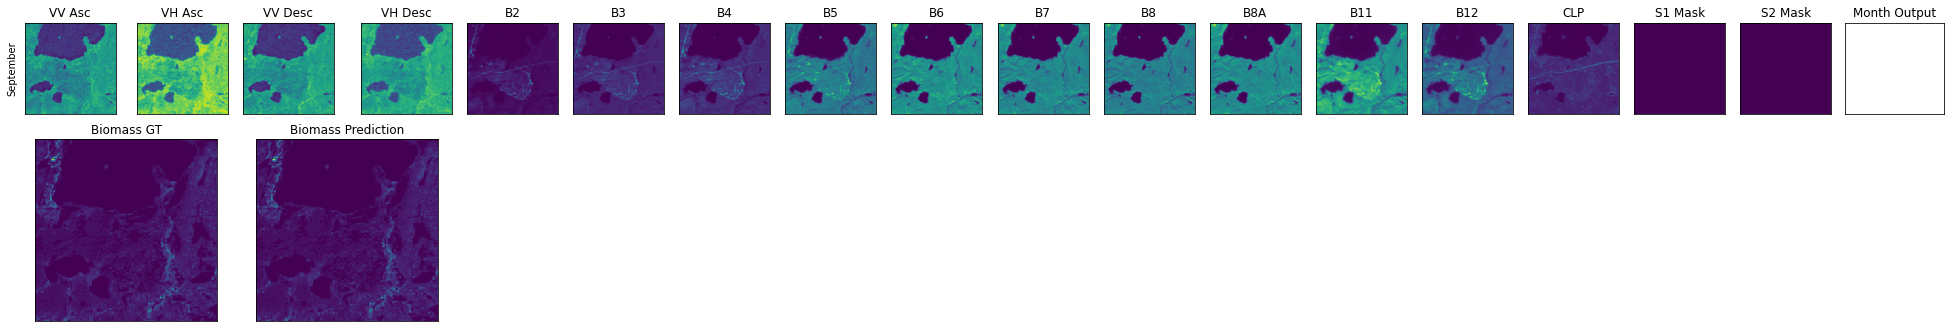

In [28]:
biomass_ds = BiomassDataset(
    dataset_dir, 'train', chip_ids=['0003d2eb'], month_items=True, transform=SentinelBandNormalize())

x, y, chip_metadata = biomass_ds[0]
print(x.shape)
print(y.shape)
print(chip_metadata.keys())

# Just pass in y as z to test the functionality
biomass_ds.plot_sample(x, y, chip_metadata, z=y)

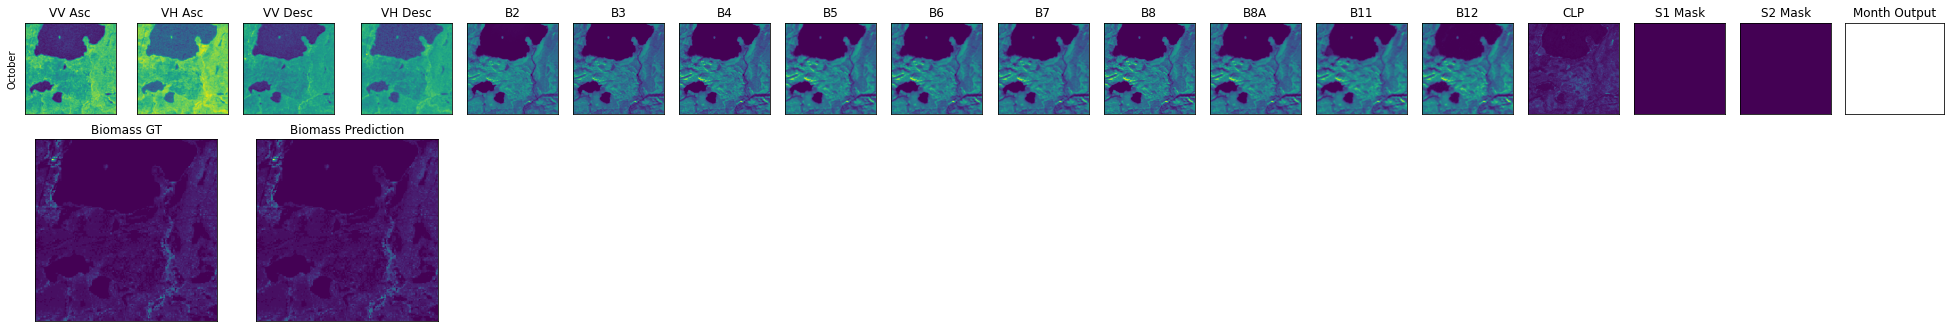

In [29]:
x, y, chip_metadata = biomass_ds[1]
biomass_ds.plot_sample(x, y, chip_metadata, z=y)

Read "best month" from each year

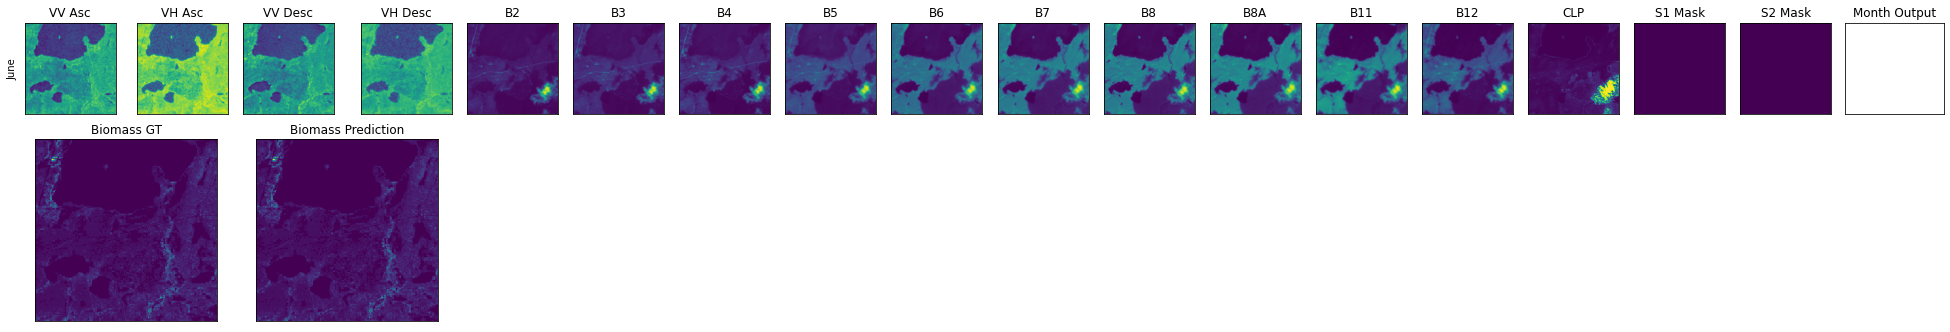

In [30]:
biomass_ds = BiomassDataset(
    dataset_dir, 'train', chip_ids=chip_ids[0:2], month_items=True, use_best_month=True, 
    transform=SentinelBandNormalize())

x, y, chip_metadata = biomass_ds[0]
biomass_ds.plot_sample(x, y, chip_metadata, z=y)

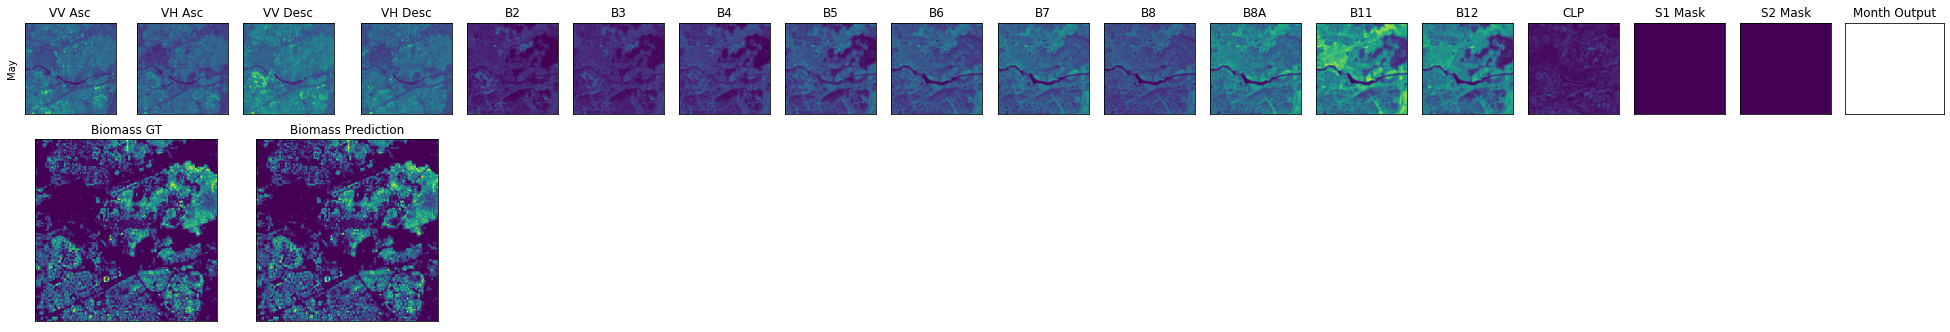

In [31]:
x, y, chip_metadata = biomass_ds[1]
biomass_ds.plot_sample(x, y, chip_metadata, z=y)

Save a plot for each chip.

In [27]:
biomass_ds = BiomassDataset(
    dataset_dir, 'train', chip_ids=chip_ids, transform=SentinelBandNormalize())

In [29]:
def plot_item(item):
    x, y, chip_metadata = item
    chip_id = chip_metadata['chip_id']
    plot_path = join(data_plots_dir, f'{chip_id}.png')
    biomass_ds.plot_sample(x, y, chip_metadata, out_path=plot_path)

pool = Pool(8)
for _ in tqdm(pool.imap_unordered(plot_item, biomass_ds), total=len(biomass_ds)):
    pass

A Jupyter Widget

## Visualize quantity of partially and fully available months

* For each chip, it's possible for some months to be missing, or for months to have data partially masked out.
* Partially available means that the month is present, but has some pixels masked out.
* Fully available means that the month is present, without any pixels masked out.



In [30]:
full_months = []
partial_months = []
for item in biomass_ds:
    chip_metadata = item[2]
    full_months.append(chip_metadata['full_months'])
    partial_months.append(chip_metadata['partial_months'])

full_months = torch.stack(full_months)
partial_months = torch.stack(partial_months)
print(full_months.shape)
print(partial_months.shape)

torch.Size([100, 12, 2])
torch.Size([100, 12, 2])


In [31]:
# convert multidim array to long form dataframe
# is there an easier way to do this?
rows = []
for chip_ind in range(full_months.shape[0]):
    for month_ind in range(12):
        month = metadata.months[month_ind][0:3]
        for sat_ind in range(2):
            sat = ['S1', 'S2'][sat_ind]
            rows.append([chip_ind, month, sat, 'full', full_months[chip_ind, month_ind, sat_ind].item()])
            rows.append([chip_ind, month, sat, 'partial', partial_months[chip_ind, month_ind, sat_ind].item()])
avail_df = pd.DataFrame(rows, columns=['chip', 'month', 'satellite', 'completeness', 'available'])
avail_df.head()


chip month satellite completeness  available
0     0   Sep        S1         full        1.0
1     0   Sep        S1      partial        1.0
2     0   Sep        S2         full        1.0
3     0   Sep        S2      partial        1.0
4     0   Oct        S1         full        1.0

How does the data availability vary by month? It looks like the S2 optical bands have more missing data in the winter.

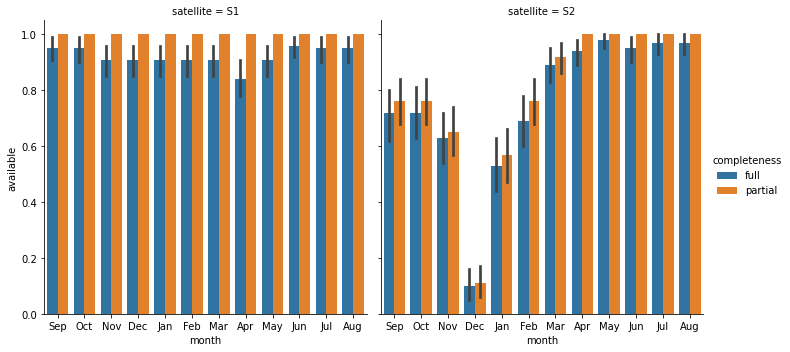

In [32]:
sns.catplot(avail_df, x='month', y='available', hue='completeness', col='satellite', kind='bar')

The same plot but averaged over months.

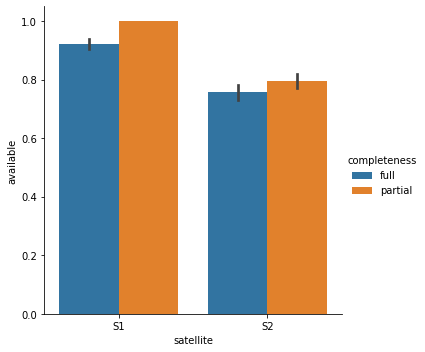

In [33]:
sns.catplot(avail_df, x='satellite', y='available', hue='completeness', kind='bar')

What is the minimum number of available months over all chips? There are some chips that have very few months of data.

/var/folders/lh/dkh8zn4124db4lr4myt8_51w0000gn/T/ipykernel_2219/4247864870.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avail_df.groupby(['chip', 'satellite', 'completeness']).agg('sum').reset_index(),


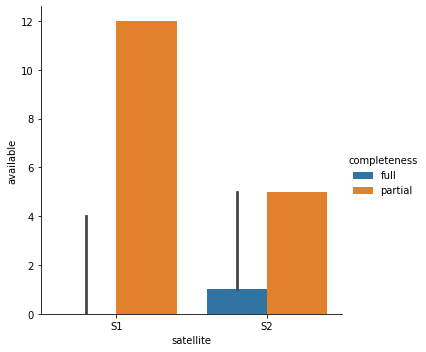

In [34]:
sns.catplot(
    avail_df.groupby(['chip', 'satellite', 'completeness']).agg('sum').reset_index(),
    x='satellite', y='available', hue='completeness', kind='bar', estimator='min')

## Visualize band distribution

Randomly sample values for each band.

In [35]:
def get_band_samples(dataset, only_full_months=True, nb_samples=1000):
    y_inds = torch.randint(0, 256 * 256, (nb_samples,))
    x_samples = []
    y_samples = []
    for x, y, chip_metadata in dataset:
        if only_full_months:
            # Only use months where there is full data for S1 and S2.
            # This allows us to filter out NODATA values which makes it easier
            # to see the distribution of non-NODATA values.
            full_months = chip_metadata['full_months']
            full_inds = (full_months.sum(1) == 2)
            if full_inds.sum() > 0:
                x = x[full_inds]
            else:
                continue
        x_inds = torch.randint(0, x.shape[0] * 256 * 256, (nb_samples,))
        x_samples.append(x.permute(1, 0, 2, 3).reshape(15, -1)[:, x_inds])
        y_samples.append(y.reshape(-1)[y_inds])
    x_samples = torch.cat(x_samples, dim=1)
    y_samples = torch.cat(y_samples)
    return x_samples, y_samples

/opt/homebrew/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


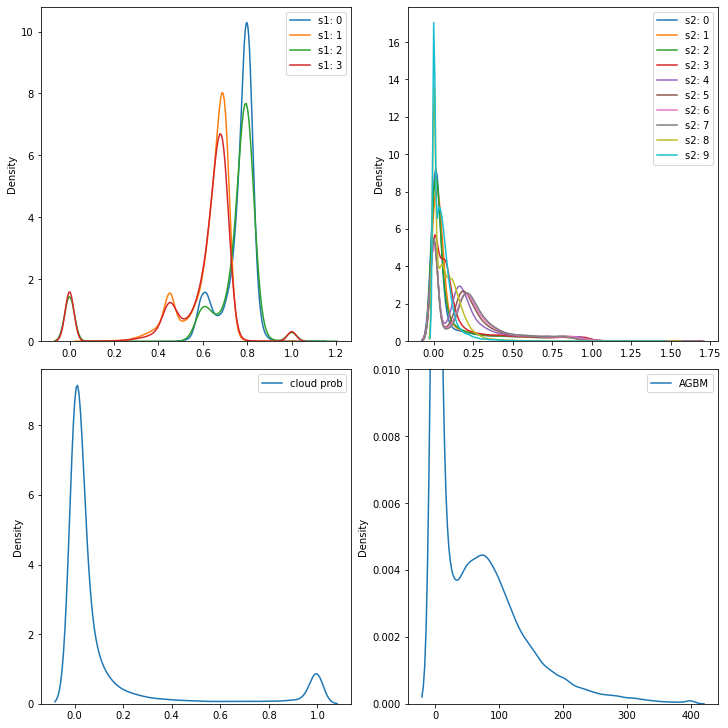

In [36]:
transform = SentinelBandNormalize()
biomass_ds = BiomassDataset(
    dataset_dir, 'train', chip_ids=chip_ids, transform=transform)
x_samples, y_samples = get_band_samples(
    biomass_ds, only_full_months=False, nb_samples=1000)

fig, axes = plt.subplots(2, 2, squeeze=True, figsize=(10, 10), constrained_layout=True)

ax = axes[0][0]
for band in range(0, 4):
    samples = x_samples[band, :]
    sns.kdeplot(x_samples[band, :], ax=ax, label=f's1: {band}')
ax.legend()

ax = axes[0][1]
for band in range(4, 14):
    sns.kdeplot(x_samples[band, :], ax=ax, label=f's2: {band - 4}')
# ax.set_ylim((0, 0.001))
ax.legend()

ax = axes[1][0]
sns.kdeplot(x_samples[14, :], ax=ax, label='cloud prob')
# ax.set_ylim((0, 0.01))
ax.legend()

ax = axes[1][1]
sns.kdeplot(y_samples, ax=ax, label=f'AGBM')
ax.set_ylim((0, 0.01))
ax.legend()